# CNN - AlexNet, ImageNet

## Load ImageNet

In [ ]:
! wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
! tar -xf ./images.tar &>/dev/null

--2023-03-19 12:52:38--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar.2’

images.tar.2        100%[===================>] 756.82M  94.8MB/s    in 8.9s    

2023-03-19 12:52:47 (84.9 MB/s) - ‘images.tar.2’ saved [793579520/793579520]

^C
mkdir: cannot create directory ‘chosen_images’: File exists


In [ ]:
!mkdir chosen_images
!cp -r Images/n02099601-golden_retriever chosen_images

In [ ]:
from torchvision.datasets import ImageFolder
import numpy as np


dataset = ImageFolder('./chosen_images')
img, label = dataset[1]
img_label = 207
img_array = np.asarray(img)

## Load AlexNet

In [ ]:
import torch
import torch.nn as nn


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier = nn.Sequential(*list(model.classifier) + [nn.Softmax(1)])
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## MaskedImage Dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from skimage.segmentation import slic


class MaskedImage(Dataset):
    def __init__(self, og_img, img_label, transform=None, segment_list = [50, 100, 150, 200, 250, 300]):
        self.og_img = og_img
        self.img_label = img_label
        self.transform = transform
        self.super_pixels = []
        img_array = np.asarray(self.og_img)
        for n_segments in segment_list:
            segments = slic(img_array, n_segments=n_segments)
            segment_values = np.unique(segments)
            for segment_value in segment_values:
                segment_mask = segments == segment_value
                self.super_pixels.append(segment_mask)
        
    def __len__(self):
        return len(self.super_pixels)
    
    def __getitem__(self, idx):
        mask = self.super_pixels[idx]
        img_array = np.asarray(self.og_img)
        img_array[mask] = 0
        masked_img = Image.fromarray(img_array)
        if self.transform:
            masked_img = self.transform(masked_img)  
        return masked_img

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

In [ ]:
masked_img_dataset = MaskedImage(img, img_label, transform=preprocess, segment_list = [50, 100, 150, 200, 250, 300])

In [ ]:
from torch.utils.data.dataloader import DataLoader


data_loader = DataLoader(masked_img_dataset, batch_size=len(masked_img_dataset), shuffle=False)
masked_images = next(iter(data_loader))

## Calculate p values

In [ ]:
def calc_p_value(input_images, img_label):
    if len(input_images.shape) == 3:
        input_images = input_images.unsqueeze(0)

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_images = input_images.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_images)


    return output[:, img_label].numpy()

## Dense Saliency Map

In [ ]:
def calc_dense_saliency_map(img, super_pixels, saliencies):
    dense_saliency_map = np.zeros(shape=(img.size[1], img.size[0]))
    for idx in range(len(saliencies)):
        mask = super_pixels[idx]
        saliency_mask = mask * saliencies[idx] * 1/np.sum(mask)
        dense_saliency_map = np.add(dense_saliency_map, saliency_mask)

    return dense_saliency_map

## MARGIN Scores for Sparsity function

### Adjacency matrix

In [ ]:
def calc_adj_matrix(saliencies):
  A_m = np.zeros(shape=(len(saliencies), len(saliencies)))
  for m_idx, m_saliency in enumerate(saliencies):
    for n_idx, n_saliency in enumerate(saliencies):
      A_m[m_idx][n_idx] = np.abs( m_saliency - n_saliency )

  return A_m

### f function

In [ ]:
def calc_f(super_pixels):
    max_size = 0
    for super_pixel in super_pixels:
        size = np.sum(super_pixel)
        if size > max_size:
            max_size = size

    f = []
    for super_pixel in super_pixels:
        f_value = np.sum(super_pixel) / max_size
        f.append(f_value)

    return f

### MARGIN

In [ ]:
import numpy as np
import networkx as nx
import scipy.sparse as sp

# Inputs:
# adj : adjacency matrix
# f : function defined at each node
# p : number of hops from each node
# for filtering
# Output:
# I : Influence score per node

def MARGIN(adj,f,p=1):
  G = nx.Graph(adj) #graph object
  N = adj.shape[0] # number of nodes
  degree = dict(G.degree())

  deg = [1./d[1] for d in degree.items()]
  Dinv = sp.csr_matrix(np.zeros((N,N)))  
  idx0,idx1 = np.diag_indices(N)
  Dinv[idx0,idx1] = deg #degree matrix

  A_norm = np.sqrt(Dinv)*adj*np.sqrt(Dinv)
  P = A_norm**p #multiple-hops

  M = np.sum(P>0,axis=1,dtype=float)

  f_filter = f-(np.matmul(P.todense(),f))/M
  I = np.abs(f_filter)
  I = I/np.max(I)

  return I.A

## Calculate I

In [ ]:
def calc_I(img, super_pixels, sparsity):
    I = np.zeros(shape=(img.size[1], img.size[0]))
    for idx in range(len(sparsity)):
        mask = super_pixels[idx]
        sparsity_mask = mask * sparsity[idx]
        I = np.add(I, sparsity_mask)

    return I

# CNN Explainability

## Calculate p values

In [ ]:
p_value_img = calc_p_value(preprocess(img), img_label)
p_values = calc_p_value(masked_images, img_label)

## Plot results

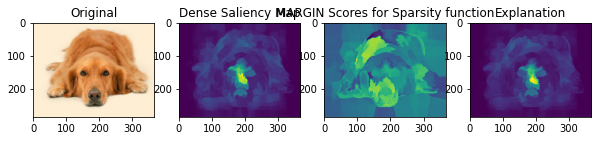

In [ ]:
import matplotlib.pyplot as plt


saliencies = np.abs(p_value_img - p_values)

super_pixels = masked_img_dataset.super_pixels

S = calc_dense_saliency_map(img, super_pixels, saliencies)

A_m = calc_adj_matrix(saliencies)
f = calc_f(super_pixels)
sparsity = MARGIN(sp.csr_matrix(A_m), f)
I = calc_I(img, super_pixels, sparsity[0])

explanation = S * I


fig, axs = plt.subplots(1, 4, figsize=(10, 3))
axs[0].imshow(np.asarray(img))
axs[0].set_title('Original')
axs[1].imshow(S)
axs[1].set_title('Dense Saliency Map')
axs[2].imshow(I)
axs[2].set_title('MARGIN Scores for Sparsity function')
axs[3].imshow(explanation)
axs[3].set_title('Explanation')



plt.show()

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-03-19 15:56:33--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-03-19 15:56:33 (76.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



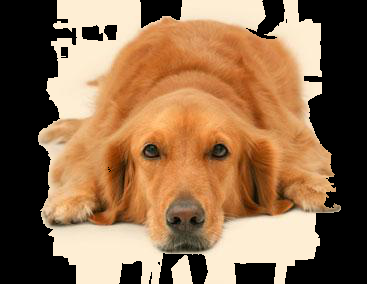

original_image:  [0.8887683]
masked image top 5:
1.  golden retriever 0.8187832236289978 tensor(207)
2.  redbone 0.0540059432387352 tensor(168)
3.  Irish setter 0.052313417196273804 tensor(213)
4.  Tibetan mastiff 0.03374942019581795 tensor(244)
5.  bloodhound 0.017888866364955902 tensor(163)


In [ ]:
import cv2

def test_masked_image(img_array):
    explanation_mask = explanation <= 0.0002
    masked_test_img_array = np.copy(img_array)
    masked_test_img_array[explanation_mask] = 0
    masked_test_img = Image.fromarray(masked_test_img_array)
    masked_test_img.show()
    og_score = calc_p_value(preprocess(img), img_label)
    print("original_image: ", og_score)
    print("masked image top 5:")
    input_image = preprocess(masked_test_img)
    input_image = input_image.unsqueeze(0)

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_image = input_image.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_image)

    # Read the categories
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(output[0], 5)
    for i in range(top5_prob.size(0)):
        print(f'{i+1}. ', categories[top5_catid[i]], top5_prob[i].item(), top5_catid[i])

test_masked_image(img_array)